#### Author：马肖
#### E-Mail：maxiaoscut@aliyun.com
#### GitHub：https://github.com/Albertsr

In [1]:
import numpy as np
import time 
%matplotlib inline
import matplotlib.pylab as plt
from PUlearning import PUlearning

from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import *
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [5]:
X, y = make_classification(n_samples=3500, n_classes=2, n_features=20, n_informative=18, 
                           n_redundant=1, weights=[0.75, 0.25], random_state=2018)

U_temp, P_temp = X[y==0], X[y==1]

P_temp_samples = P_temp.shape[0]
P_size = int(0.85 * P_temp_samples)

np.random.seed(2018)
rp = np.random.permutation(P_temp_samples)

# 在P_temp中随机抽取P_size个样本作为真正的P
P = P_temp[rp[:P_size]]
P_label = np.ones(P_size)

# 构造无标签样本集U，其中包含少量的异常样本
U = np.r_[U_temp, P_temp[rp[P_size:]]]
print('real RN:', len(U_temp))
U_label = np.r_[np.zeros(U_temp.shape[0]), np.ones(P_temp_samples-P_size)]

real RN: 2617


#### 观察模型各项指标随着sample_ratio增加的变化趋势

sample_ratio: 0.95 0.31590909090909086 0.909090909090909 0.909090909090909 0.9295454545454545


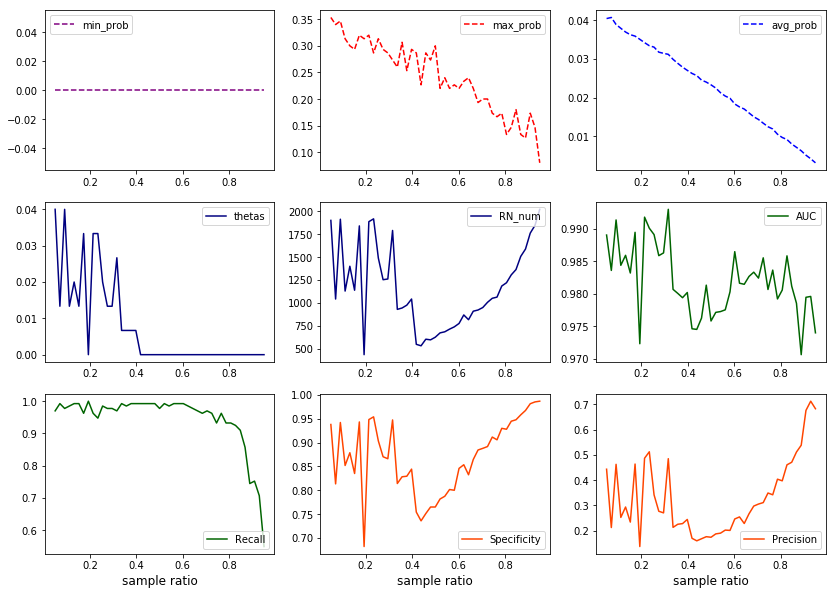

Time spending: 168.17s


In [3]:
clf1 = RandomForestClassifier(n_estimators=150, random_state=2018)
clf2 = XGBClassifier(n_estimators=250, learning_rate=0.75)

sample_ratios = np.linspace(0.05, 0.95, 45)
thetas, RN_num, min_prob, max_prob, avg_prob = [], [], [], [], []
accs, aucs, f_scores, ap_scores, recalls, specificitys, precisions = [], [], [], [], [], [], []

start = time.time()
for i in sample_ratios:
    a = PUlearning(P, U, clf1=clf1, clf2=clf2, sample_ratio=i, over_sample=False)
    RN, theta, min_U_prob, max_U_prob, avg_U_prob = a.reliable_negative_set()
    y_pred, y_prob = a.predict()
    
    tn, fp, fn, tp = confusion_matrix(U_label, y_pred).ravel()
    acc = accuracy_score(U_label, y_pred)
    auc = roc_auc_score(U_label, y_prob)
    f_score = f1_score(U_label, y_pred)
    ap_score = average_precision_score(U_label, y_pred)
    recall = recall_score(U_label, y_pred)
    specificity = tn / (tn + fp)
    precision = precision_score(U_label, y_pred)
    
    thetas.append(theta)
    min_prob.append(min_U_prob)
    max_prob.append(max_U_prob)
    avg_prob.append(avg_U_prob)
    RN_num.append(len(RN))
    recalls.append(recall)
    aucs.append(auc)
    f_scores.append(f_score)
    ap_scores.append(ap_score)
    accs.append(acc)
    specificitys.append(specificity)
    precisions.append(precision)
    
    
s_max_RN = sample_ratios[np.argmax(RN_num)]
s_max_AUC = sample_ratios[np.argmax(aucs)]
s_max_Fscore = sample_ratios[np.argmax(f_scores)]
s_max_APscore = sample_ratios[np.argmax(ap_scores)]
s_max_ACC = sample_ratios[np.argmax(accs)]
print('sample_ratio:', s_max_RN, s_max_AUC, s_max_Fscore, s_max_APscore, s_max_ACC)
    
plt.figure(figsize=(14, 10))    

plt.subplot(331)
plt.plot(sample_ratios, min_prob, label='min_prob', c='purple', ls='--')
plt.legend(loc='upper left')

plt.subplot(332)
plt.plot(sample_ratios, max_prob, label='max_prob', c='r', ls='--')
plt.legend(loc='upper right')

plt.subplot(333)
plt.plot(sample_ratios, avg_prob, label='avg_prob', c='b', ls='--')
plt.legend(loc='upper right')

plt.subplot(334)
plt.plot(sample_ratios, thetas, label='thetas', c='navy')
plt.legend(loc='upper right')

plt.subplot(335)
plt.plot(sample_ratios, RN_num, label='RN_num', c='navy')
plt.legend(loc='upper right')

plt.subplot(336)
plt.plot(sample_ratios, aucs, label='AUC', c='darkgreen')
plt.legend(loc='upper right')

plt.subplot(337)
plt.plot(sample_ratios,recalls, label='Recall', c='darkgreen')
plt.legend(loc='lower right')
plt.xlabel('sample ratio', fontsize=12)

plt.subplot(338)
plt.plot(sample_ratios, specificitys, label='Specificity', c='orangered')
plt.legend(loc='lower right')
plt.xlabel('sample ratio', fontsize=12)

plt.subplot(339)
plt.plot(sample_ratios, precisions, label='Precision', c='orangered')
plt.legend(loc='lower right')
plt.xlabel('sample ratio', fontsize=12)
plt.show()
end = time.time()
print('Time spending: {:.2f}s'.format(end - start))

### 总结

#### 1. sample_ratio不能太高
- sample_ratio太高时，模型为了将spy中的样本分类为负样本，决策边界会显著趋近于正样本集，表现为模型将样本预测为正样本的条件概率P(1|x)偏小
- max_prob、avg_prob的趋势曲线说明了概率预测值P(1|x)随着sample_ratio的上升而逐步减小，min_prob曲线则与具体的负样本有关
- 随着sample_ratio的上升，概率预测值P(1|x)的下降导致FN在增加，FP在减小，recall曲线、Specificity曲线、Precision曲线的趋势证明了这一点
  
  
#### 2. sample ratio在一定区间内变化时，模型对正负样本的区分能力可能处于震荡状态
- 这种情况下，临近**模型决策边界**两边的正负样本相似度越来越高，模型难以准确地学习到理想决策边界，表现为AUC等指标上下震荡甚至逐渐恶化

  
#### 3. sample ratio较小时，生成的theta是否适宜与数据集本身的特点有关
- 选取到的间谍样本也许具有非常明显的正样本特质，模型为了将其预测为负样本，决策样本大幅向正样本移动，导致theta偏低，RN的样本数偏多，混入了较多的正样本
- 选取到的间谍样本的正样本特质不明显，决策边界轻微调整便可将其预测为负样本，生成的theta随机性较大，不能很好地判定RN

#### 4. sample ratio的经验取值为0.15
- 论文《Partially Supervised Classification of Text Documents》中比较了5%、10%、20%, 结果相差不大